 # 📡 Supervised methods - sarcasm detector

Dataset original source

- [News Headlines](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

Dataset content

- is_sarcastic: 1 if the record is sarcastic otherwise 0

- headline: the headline of the news article

- article_link: link to the original news article. Useful in collecting supplementary data

Inspiration

- Can you identify sarcastic sentences? Can you distinguish between fake news and legitimate news?


Build a predictive model

- Compare: NB, KNN, SVM

Knowledge and tools references

- [NB](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [KNN](https://www.codecademy.com/learn/introduction-to-supervised-learning-skill-path/modules/k-nearest-neighbors-skill-path/cheatsheet)
- [SVM](https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte)
- [ROC curve](https://stackabuse.com/understanding-roc-curves-with-python/)
- [One Hot Encoder](https://datagy.io/sklearn-one-hot-encode/)
- [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
- [NB](https://scikit-learn.org/stable/modules/naive_bayes.html)
- [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
- [Hyper parameter tunning](https://medium.com/@kocur4d/hyper-parameter-tuning-with-pipelines-5310aff069d6)

## 🏷 Table of content
* 📝 Libraries
* 🔡 The data
* 🕵 Exploratory data analysis
* 🔨 How to vectorize text
* 🔮 End to end modeling
* 🚀 Ensemble
* 🧐 Conclusions

## 📝 Libraries <a class="anchor" id="libraries"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
import scipy
from time import time
import os

import nltk 
# IMPORNTANT: install this the first time
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

There is a notebook session saved in the environment


## 🔡 The data <a class="anchor" id="the-data"></a>

In [2]:
dataset_name = 'Sarcasm_Headlines_Dataset_v2.json'
X_a = pd.read_json(dataset_name, lines=True)

In [3]:
X_a.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## 🕵 Exploratory data analysis

In [4]:
X_a.shape

(28619, 3)

In [5]:
X_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [6]:
X_a.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

### Get ride of duplicated headlines

In [7]:
X_a['headline'].duplicated().sum()

116

In [8]:
X_a[X_a['headline'].duplicated()].index

Int64Index([ 1780,  3978,  4771,  4904,  5092,  5684,  5806,  6148,  6237,
             6607,
            ...
            27929, 27935, 28035, 28072, 28086, 28235, 28246, 28449, 28456,
            28595],
           dtype='int64', length=116)

In [9]:
X_a = X_a.drop(X_a[X_a['headline'].duplicated()].index, axis=0)

In [10]:
X_a['headline'].duplicated().sum()

0

In [11]:
X_a.shape

(28503, 3)

### Get ride of duplicate features

In this section, we observe high correlation between the font size of the headline and whether or not it is sarcastic. With this information I could create model with high accuracy but really dependent from the font. As I would like a model this information will be dropped at the training stage.

#### The transmitter

In [12]:
df = X_a.copy()

In [13]:
extract_transmitter = lambda url : url.split('.')[1]
df['transmitter'] = df['article_link'].apply(extract_transmitter)
df.head()

,is_sarcastic,headline,article_link,transmitter
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,theonion
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,theonion


#### Distributions

In this section you notice that:

- The dependent variable is unbalanced
- Using feature engineering we can find a variable that predicts with 100% of accuracy if it's a sarcastic quote or not but the models will not be portables.

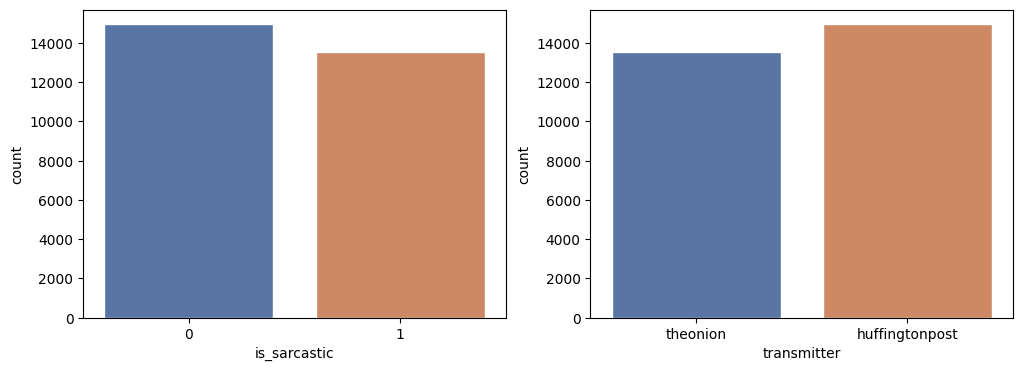

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.set_theme(style='whitegrid')
ax = sns.countplot(x='is_sarcastic', data=df, ax = ax1)

sns.set_theme(style='whitegrid')
ax = sns.countplot(x='transmitter', data=df, ax = ax2)

In [15]:
df['is_sarcastic'].value_counts()

0    14951
1    13552
Name: is_sarcastic, dtype: int64

In [16]:
df['transmitter'].value_counts()

huffingtonpost    14951
theonion          13552
Name: transmitter, dtype: int64

#### Linear correlation between features

It's important to note that a matrix of all ones is a very unlikely scenario in real-world data, as it would indicate that all of the variables are perfectly correlated and there is no variability or uniqueness in the data. However, with this information, I deduce that the The Onion source always throws sarcastic headlines, while Huffington Post always gives non-sarcastic headlines.

The conclusion here is that if I maintain the transmitter feature created from feature engineering, I am more likely to create an accurate model with the disadvantage of needing the source of the headline.

In [17]:
from pandas import factorize
columns = ['transmitter', 'is_sarcastic']
X = df[columns]
X.loc[:, 'transmitter'] = factorize(X['transmitter'])[0]

In [18]:
# calculate the correlation matrix
corr = X.corr()
corr

,transmitter,is_sarcastic
transmitter,1.0,-1.0
is_sarcastic,-1.0,1.0


## 🔨 How to vectorize text?

In this section I present the way I map from raw text to vectorized samples in order to inject the vectorized samples into M.L models

### Denoise headlines

In this section I present the way I clean the text and transform to simple phrases using the **nltk** library and removing stop words

In [19]:
def denoise_text(text: str):
    
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    
    def concat(tokens):
        return ' '.join(tokens)

    # lower case
    text = text.lower()
    
    # remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]
    
    # remove stop words
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    
    # stem words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return concat(tokens)

In [20]:
df['clean_headline'] = df['headline'].apply(denoise_text)
df[['headline', 'clean_headline']].head(10)

,headline,clean_headline
0,thirtysomething scientists unveil doomsday clo...,thirtysometh scientist unveil doomsday clock h...
1,dem rep. totally nails why congress is falling...,dem rep total nail congress fall short gender ...
2,eat your veggies: 9 deliciously different recipes,eat veggi delici differ recip
3,inclement weather prevents liar from getting t...,inclement weather prevent liar get work
4,mother comes pretty close to using word 'strea...,mother come pretti close use word stream corre...
5,my white inheritance,white inherit
6,5 ways to file your taxes with less stress,way file tax le stress
7,richard branson's global-warming donation near...,richard branson global warm donat nearli much ...
8,shadow government getting too large to meet in...,shadow govern get larg meet marriott confer ro...
9,lots of parents know this scenario,lot parent know scenario


#### Most commond words in headlines

In this section, you'll see the most recurrent words used in sarcastic headlines and in non-sarcastic headlines. This may give us an idea of how to distinguish sarcastic quotes from non-sarcastic quotes.

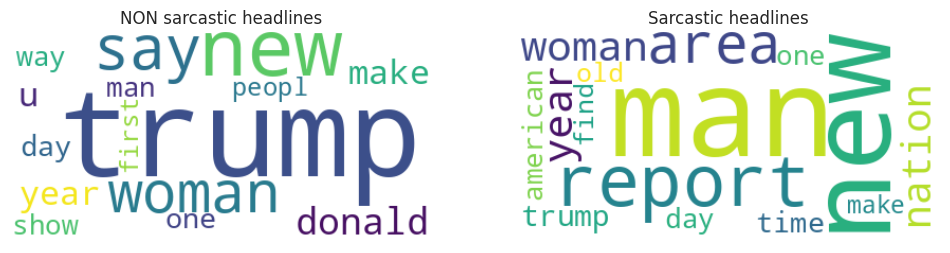

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# more frequent words used in not sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 0]['clean_headline'])
wc = WordCloud(
    max_words = 15, 
    collocations = False, 
    background_color = 'white') \
    .generate(ns_words)
ax1.imshow(wc , interpolation = 'bilinear')
ax1.axis('off')
ax1.set_title('NON sarcastic headlines')


# more frequent words used in sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 1]['clean_headline'])
wc = WordCloud(max_words = 15, collocations = False, background_color = 'white').generate(ns_words)
ax2.imshow(wc , interpolation = 'bilinear')
ax2.axis("off")
ax2.set_title('Sarcastic headlines')


plt.show()

### Vectorize words

In order to provide additional context for the machine learning algorithm, I will use ngrams of size 1 and 2. This will increase the amount of data, but I anticipate that it will improve the accuracy of the algorithm.

But here, as a demostration, I just use ngrams of size 1.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = df['clean_headline']
vectorizer = CountVectorizer(
    dtype='int32', 
    analyzer='word', 
    ngram_range=(1,1),
    min_df=1)
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

In [23]:
X.shape

(28503, 17579)

In [24]:
feature_names[100:125]

array(['abaya', 'abba', 'abbey', 'abbi', 'abc', 'abdeslam', 'abdomen',
       'abdomin', 'abduct', 'abdul', 'abe', 'abedin', 'abhorr', 'abid',
       'abil', 'abject', 'abl', 'aboard', 'abolish', 'abomin', 'abort',
       'aboveground', 'abraham', 'abram', 'abramson'], dtype=object)

In [25]:
# X.toarray() <- Even decreasing the number of bits to representing the data, it does not work, I have 8gb of ram and it exceeds 14gb
sdf = pd.DataFrame.sparse.from_spmatrix(X)
sdf[['is_sarcastic', 'transmitter']] = df[['is_sarcastic', 'transmitter']]

In [26]:
sdf[list(range(10)) + ['is_sarcastic', 'transmitter']].head()

,0,1,2,3,4,5,6,7,8,9,is_sarcastic,transmitter
0,0,0,0,0,0,0,0,0,0,0,1.0,theonion
1,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost
2,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost
3,0,0,0,0,0,0,0,0,0,0,1.0,theonion
4,0,0,0,0,0,0,0,0,0,0,1.0,theonion


## 🔮 End to End Modeling

To ensure that this project is easily transferable, I will employ an end-to-end design pattern. In brief, this approach involves incorporating data transformations and modeling into a single workflow. Since I am utilizing sklearn, I will utilize the Pipelines and Transformers from this library.

To be able to do that, I need to encapsulate the logic of denoise text saw above into a Transformer to add into a Pipeline.

### Transformations

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformers

# cleans noise from raw text
class TextDenoiser(BaseEstimator, TransformerMixin):
    
    def __denoise_text(self, text):
        from nltk.tokenize import RegexpTokenizer
        from nltk.corpus import stopwords
        from nltk.stem import PorterStemmer, WordNetLemmatizer
        
        def concat(tokens):
            return ' '.join(tokens)

        # lower case
        text = text.lower()

        # remove punctuation
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)

        # remove numbers
        tokens = [token for token in tokens if not token.isnumeric()]

        # remove stop words
        stop_words = stopwords.words('english')
        tokens = [token for token in tokens if token not in stop_words]

        # stem words
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

        # lemmatize words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return concat(tokens)

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for c in X.columns:
            X[c] = X[c].apply(self.__denoise_text)
        return X

    
# Transform url into transmitter categorical variable 
# (NOT USED ANYMORE as I see this features give me height performance but It makes models dependent from this variable and I dont want it!)
class TransmitterExtracter(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # self.input_features = X.columns
        return self
    
    def __extracter(self, text):
        return text.split('.')[1]

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for c in X.columns:
            X[c] = X[c].apply(self.__extracter)
        return X

In [30]:
text_processor_pipeline = Pipeline(steps=[
            ('denoiser', TextDenoiser()),
            ('ct', ColumnTransformer(transformers=[
                ('v', CountVectorizer(
                        dtype='int32',
                        analyzer='word',
                        min_df=1), 0)
                ])
            )
  ])

# Column transformer get's ride of no transformed columns
preprocessor = ColumnTransformer(
    transformers=[('tf1', text_processor_pipeline, ['headline'])],
)

In [31]:
X = X_a.drop(['is_sarcastic', 'article_link'], 1)
y = X_a['is_sarcastic']
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=0, stratify=y.to_numpy())

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

type(X_train), type(y_train)

(scipy.sparse._csr.csr_matrix, pandas.core.series.Series)

In [33]:
print('Training dataset shape features', X_train.shape)
print('Training dataset shape labels', y_train.shape)
print('Test dataset shape features', X_test.shape)
print('Test dataset shape labels', y_test.shape)

Training dataset shape features (24227, 16445)
Training dataset shape labels (24227,)
Test dataset shape features (4276, 16445)
Test dataset shape labels (4276,)


### Modeling

As we observed in the Exploratory Data Analysis section, the data is unbalanced. To address this issue, as the majority of sentences are non-sarcastic, I will:

- Implement stratified sampling based on the dependent variable, to ensure that the test dataset has the same distribution as the original set.

- Implement undersampling to decrease the number of samples in the majority class.

- Reserve 15% of the original dataset as a test set. The test set resulting from the undersampling process will have around 25K samples, therefore the validation test set will have around 3K-4K samples.

- Utilize GridSearchCV to tune the hyperparameters of the transformations and models simultaneously, by applying 5-fold cross-validation to the training set.

- For each trained model, I will display its corresponding confusion matrix, ROC curve, and other statistics such as training time, the score of the best model for the training test and the sample test.

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y.to_numpy())

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

print('Original dataset train shape %s' % Counter(y_train))
print('Resampled dataset train shape %s' % Counter(y_res))

Original dataset train shape Counter({0: 12708, 1: 11519})
Resampled dataset train shape Counter({0: 11519, 1: 11519})


UOC (Unified Operating Characteristic) curve is a statistical tool that is used to evaluate the performance of a binary classifier. It helps to visualize the trade-off between the true positive rate (TPR, or sensitivity) and the false positive rate (FPR, or 1-specificity) across different threshold values. The UOC curve is a way to summarize the performance of a classifier in a single plot, and it is useful to compare the performance of different models or different evaluation metrics. The UOC curve is useful because it allows you to see the effects of different threshold values on the classifier's performance, which can be especially useful when you are trying to optimize the classifier for a specific application.

In [38]:
def plot_roc_curve(pipe, X_test, y_test):
    from sklearn.metrics import RocCurveDisplay
    _ = RocCurveDisplay.from_estimator(pipe, X_test, y_test)

A confusion matrix is a table that is used to define the performance of a classification algorithm, it is also known as an error matrix. It is a table with two dimensions where the rows represents the predicted class and the columns represents the actual class. It is often used to describe the performance of a classification algorithm, including binary or multi-class classification. It allows the visualization of the performance of an algorithm, including true positives, true negatives, false positives and false negatives. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. It also allows you to compute various performance metrics such as accuracy, precision, recall, F1-score and so on.

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, predictions, classes):
    print(y_test.shape, predictions.shape)
    cm = confusion_matrix(y_test, predictions, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes)
    disp.plot()
    plt.show()

In [40]:
# Here I save the best models
M = {}

#### 📍Multinomial NB

In [43]:
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('mnb', MultinomialNB())
])

alphas = [0.05,0.1,0.5,1.0,2.0,4.0]

ngrams = [(1, 1), (1, 2)]

grid_params = {
  'mnb__alpha': alphas,
  'mnb__fit_prior': [True],  
  'preprocessor__tf1__ct__v__ngram_range': ngrams
}

start=time()

gs_mnb = GridSearchCV(
    pipe, 
    grid_params, 
    cv = 5,
    scoring = 'f1',
    n_jobs=-1
)
gs_mnb.fit(X_res, y_res)

elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  48.89  seconds


In [44]:
# getting the best accuracy and parameters
print('MNB Train Accuracy : %.3f' %  gs_mnb.best_estimator_.score(X_res, y_res))
print('MNB Test Accuracy : %.3f' %  gs_mnb.best_estimator_.score(X_test, y_test))
print('MNB Best Accuracy Through Grid Search : %.3f' % gs_mnb.best_score_)
print('MNB Best Parameters : ', gs_mnb.best_params_)

MNB Train Accuracy : 0.970
MNB Test Accuracy : 0.791
MNB Best Accuracy Through Grid Search : 0.797
MNB Best Parameters :  {'mnb__alpha': 2.0, 'mnb__fit_prior': True, 'preprocessor__tf1__ct__v__ngram_range': (1, 2)}


(4276,) (4276,)


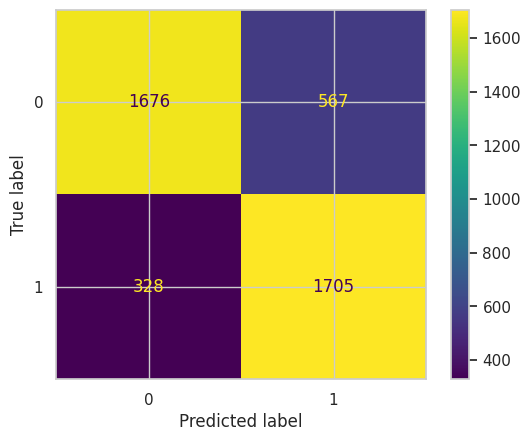

In [45]:
pipe_nb = gs_mnb.best_estimator_
y_pred = pipe_nb.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe_nb.classes_)

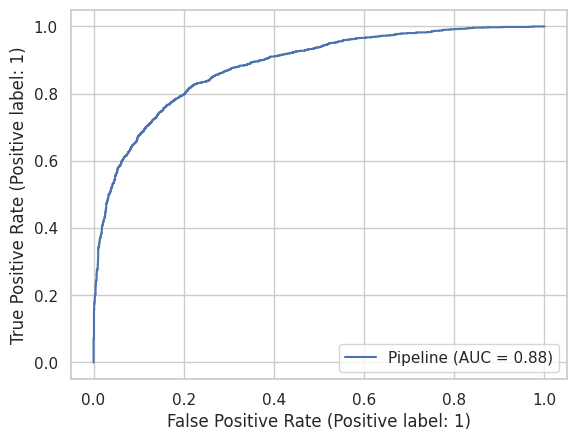

In [46]:
plot_roc_curve(pipe_nb, X_test, y_test)

In [47]:
M['multinomial_nb'] = {
    'gsearch': gs_mnb,
    'time': elapsed
}

#### 📍KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline ([
    ('preprocessor', preprocessor),
    ('tfidf', TfidfTransformer()),
    ('knn', KNeighborsClassifier(algorithm='brute', weights='uniform', metric='minkowski')) # note: kd_tree is not supported in sparse matrix
])

ngrams = [(1, 1), (1, 2)]

grid_params = {
  'knn__n_neighbors': [15,30,45,60,75,90],
  'preprocessor__tf1__ct__v__ngram_range': ngrams,
  'knn__p': [1, 2],
  'knn__leaf_size': [10, 20]
}

start=time()
gs_knn = GridSearchCV(
    pipe, 
    grid_params, 
    cv = 5,
    scoring = 'f1',
    n_jobs=-1
)

gs_knn.fit(X_res, y_res)
elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  346.33  seconds


In [51]:
# getting the best accuracy and parameters
print('KNN Train Accuracy : %.3f' %  gs_knn.best_estimator_.score(X_res, y_res))
print('KNN Test Accuracy : %.3f' %  gs_knn.best_estimator_.score(X_test, y_test))
print('KNN Best Accuracy Through Grid Search : %.3f' % gs_knn.best_score_)
print('KNN Best Parameters : ', gs_knn.best_params_)

KNN Train Accuracy : 0.740
KNN Test Accuracy : 0.725
KNN Best Accuracy Through Grid Search : 0.680
KNN Best Parameters :  {'knn__leaf_size': 10, 'knn__n_neighbors': 75, 'knn__p': 2, 'preprocessor__tf1__ct__v__ngram_range': (1, 2)}


(4276,) (4276,)


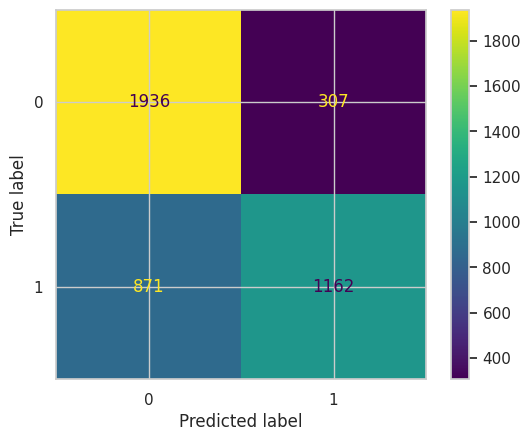

In [52]:
pipe_knn = gs_knn.best_estimator_
y_pred = pipe_knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe_knn.classes_)

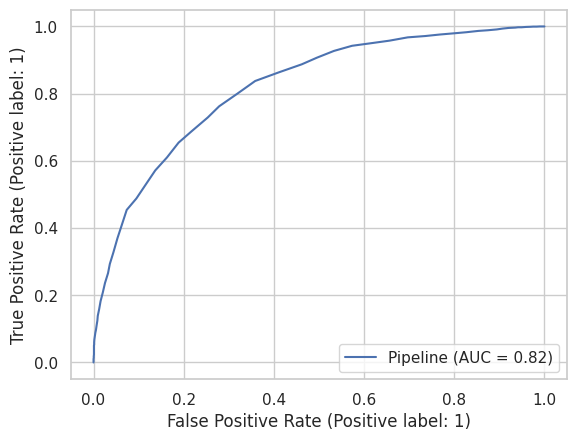

In [53]:
plot_roc_curve(pipe_knn, X_test, y_test)

In [54]:
M['knn'] = {
    'gsearch': gs_knn,
    'time': elapsed
}

#### 📍SVM

In [57]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

text_processor_pipeline = Pipeline(steps=[
            ('denoiser', TextDenoiser()),
            ('ct', ColumnTransformer(transformers=[
                ('v', CountVectorizer(
                        dtype='int32',
                        analyzer='word',
                        min_df=1), 0)
                ])
            ),
            ('scaler', StandardScaler(with_mean=False))
  ])

# Column transformer get's ride of no transformed columns
preprocessor = ColumnTransformer(
    transformers=[
        #('tf1', transmitter_processor_pipeline, ['article_link']),
        ('tf1', text_processor_pipeline, ['headline']),
    ],
    #remainder='passthrough'
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

ngrams = [(1, 1), (1, 2)]

grid_params = {
    'svc__C': [0.1, 0.9, 9],
    'svc__kernel': ['linear', 'rbf'],
    'svc__cache_size': [ 200, 400 ],
    'preprocessor__tf1__ct__v__ngram_range': ngrams,
}

start=time()

gs_svm = GridSearchCV(
    pipe, 
    grid_params, 
    cv = 5,
    scoring = 'f1',
    n_jobs=-1
)
gs_svm.fit(X_res, y_res)

elapsed = time() - start
print("CV trainning took: ", round(elapsed, 2), " seconds")

CV trainning took:  1472.83  seconds


In [58]:
# getting the best accuracy and parameters
print('SVM Train Accuracy : %.3f' %  gs_svm.best_estimator_.score(X_res, y_res))
print('SVM Test Accuracy : %.3f' %  gs_svm.best_estimator_.score(X_test, y_test))
print('SVM Best Accuracy Through Grid Search : %.3f' % gs_svm.best_score_)
print('SVM Best Parameters : ', gs_svm.best_params_)

SVM Train Accuracy : 0.948
SVM Test Accuracy : 0.757
SVM Best Accuracy Through Grid Search : 0.740
SVM Best Parameters :  {'preprocessor__tf1__ct__v__ngram_range': (1, 1), 'svc__C': 0.9, 'svc__cache_size': 200, 'svc__kernel': 'rbf'}


(4276,) (4276,)


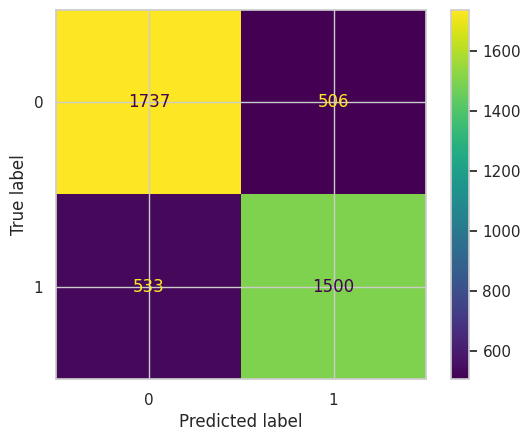

In [59]:
pipe_svc = gs_svm.best_estimator_
y_pred = pipe_svc.predict(X_test)
plot_confusion_matrix(y_test, y_pred, pipe_svc.classes_)

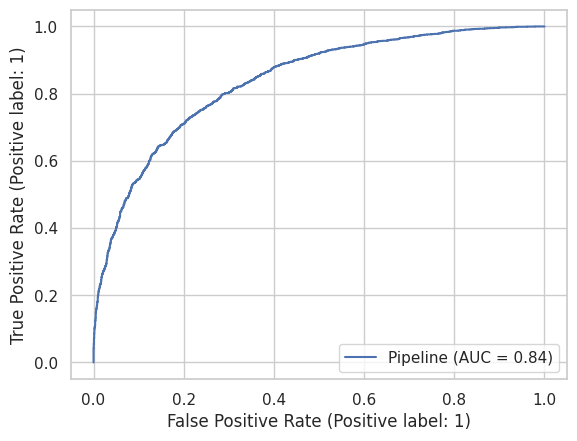

In [60]:
plot_roc_curve(pipe_svc, X_test, y_test)

In [61]:
M['svm'] = {
    'gsearch': gs_svm,
    'time': elapsed
}

## 🚀 Ensemble

I have observed that while the Multinomial Naive Bayes and SVM models have high performance on the training set, they are overfitting as their accuracy on the test set decreases significantly. On the other hand, the KNN model has poor performance in both the training and validation sets, which is why I have decreased its importance in the ensemble.

In [77]:
from sklearn.ensemble import VotingClassifier

estimators = []
for estimator_name, data in M.items():
    if estimator_name == 'ensemble':
        continue
    print('appening estimator: ' + estimator_name)
    estimator = data['gsearch'].best_estimator_
    estimators.append((estimator_name, estimator))
    
ensemble = VotingClassifier(estimators, voting='hard', n_jobs=-1, weights=[1.25, 1, 1.25])
start = time()
ensemble.fit(X_res, y_res)
elapsed = time() - start
print("Ensemble took: ", round(elapsed, 2), " seconds")
print('Ensemble Train Accuracy : %.3f' %  ensemble.score(X_res, y_res))
print('Ensemble Test Accuracy : %.3f' %  ensemble.score(X_test, y_test))
M['ensemble'] = {
    'ensemble': ensemble, # PSS. take care in the bucle bellow!
    'time': elapsed
}

appening estimator: multinomial_nb
appening estimator: knn
appening estimator: svm
Ensemble took:  73.32  seconds
Ensemble Train Accuracy : 0.946
Ensemble Test Accuracy : 0.796


(4276,) (4276,)


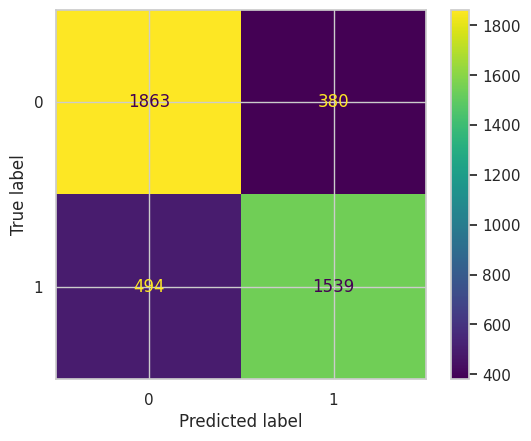

In [87]:
plot_confusion_matrix(y_test, y_pred, ensemble.classes_)

## 🧐 Conclusions

As we can see from the following lines of code and graphics, Multinomial Naive Bayes not only performs better when compared to other models during testing, but also has a significantly faster training time than the other models. While other models such as KNN and SVM take almost 5 minutes and a half hour respectively, Naive Bayes' training time is less than a minute. Although SVM has better performance compared to KNN, its training time is 5 times longer. To avoid this issue, I would recommend using KNN instead of SVM despite its slightly poorer performance of 5 percentiles.

The best model for this sarcasm classification task was found to be Multinomial Naive Bayes. However, using a VotingClassifier as a assembler with multiple tree models improved performance. However, this approach requires training multiple tree models and the benefits are not significantly different from using just Multinomial Naive Bayes alone, although of course the ensemble model is less overfitted and has high variance in testing set.

In [84]:
import os
from sklearn import metrics

does_exist = os.path.exists('./metrics.csv')
recover = False

if does_exist and recover:
    df = pd.read_csv('./metrics.csv')
else:
    precision_score = []
    recall_score = []
    f1_score = []
    accuracy_score = []
    train_accuracy_score = []
    times = []
    model_names = []
    
    for name, data in M.items():
        
        if data.get('gsearch') is None:
            model = data['ensemble']
        else:
            model = data['gsearch'].best_estimator_
        
        train_time = data['time']
        y_pred = model.predict(X_test)

        model_names.append(name)
        times.append(round(train_time, 2))
        precision_score.append(round(metrics.precision_score(y_test, y_pred, average='weighted'), 3))
        recall_score.append(round(metrics.recall_score(y_test, y_pred, average='weighted'), 3))
        f1_score.append(round(metrics.f1_score(y_test, y_pred, average='weighted'), 3))
        accuracy_score.append(round(metrics.accuracy_score(y_test , y_pred), 3))
        train_accuracy_score.append(round(model.score(X_res, y_res), 3))
        
    columns = {
        'precision_score':  precision_score, 
        'recall_score': recall_score,
        'f1_score': f1_score,
        'accuracy_score' : accuracy_score,
        'train_accuracy_score': train_accuracy_score,
        'train_time': times,
    }
    
    df = pd.DataFrame(columns, index = model_names)
    df.to_csv('metrics.csv', index = True)
    
df = df.sort_values('f1_score', ascending = False)
df

,precision_score,recall_score,f1_score,accuracy_score,train_accuracy_score,train_time
ensemble,0.796,0.796,0.795,0.796,0.946,73.32
multinomial_nb,0.795,0.791,0.791,0.791,0.970,48.89
svm,0.757,0.757,0.757,0.757,0.948,1472.83
knn,0.738,0.725,0.718,0.725,0.740,346.33


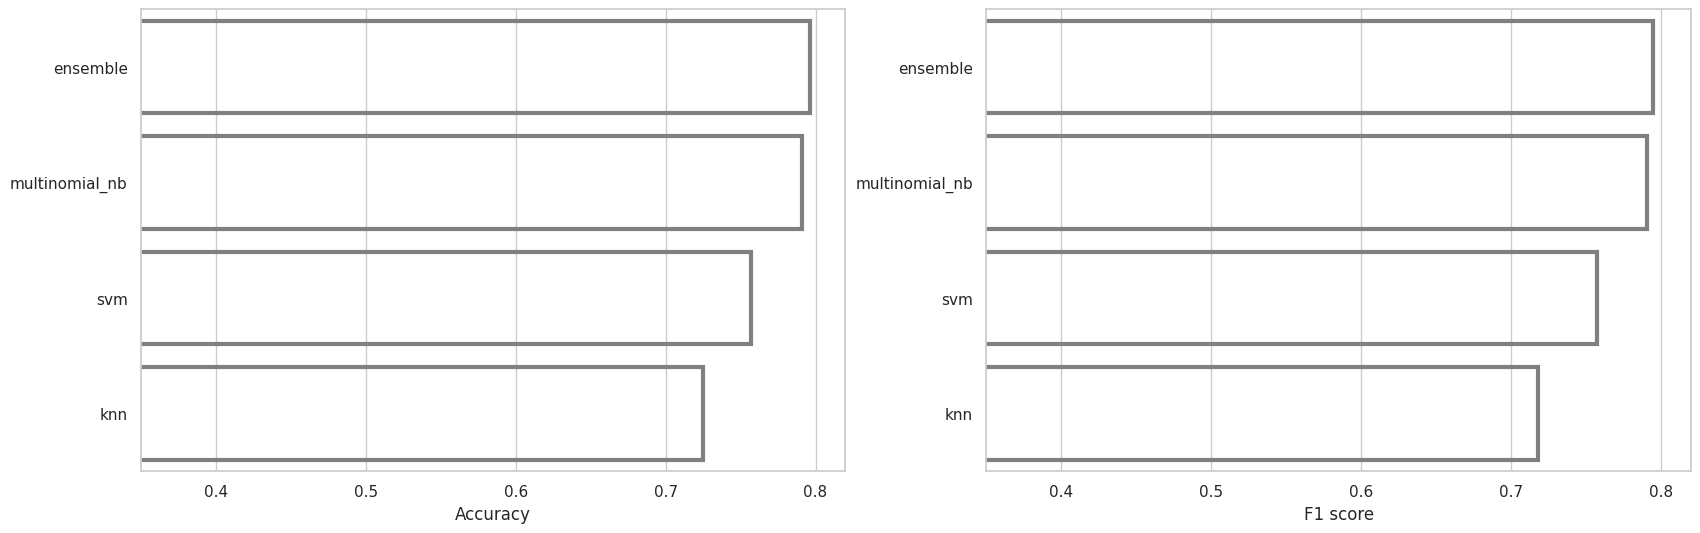

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax = sns.barplot(
            data=df, 
            y=df.index, 
            x=df["accuracy_score"],
            capsize=.4,
            linewidth=3, 
            edgecolor=".5", 
            facecolor=(0, 0, 0, 0),
            ax=ax1)
_ = ax.axes.set_xlim((0.35, 0.82))
_ = ax.axes.set(xlabel ="Accuracy")


ax = sns.barplot(
            data=df, 
            y=df.index, 
            x=df["f1_score"],
            capsize=.4,
            linewidth=3, 
            edgecolor=".5", 
            facecolor=(0, 0, 0, 0),
            ax=ax2)
_ = ax.axes.set_xlim((0.35, 0.82))
_ = ax.axes.set(xlabel ="F1 score")

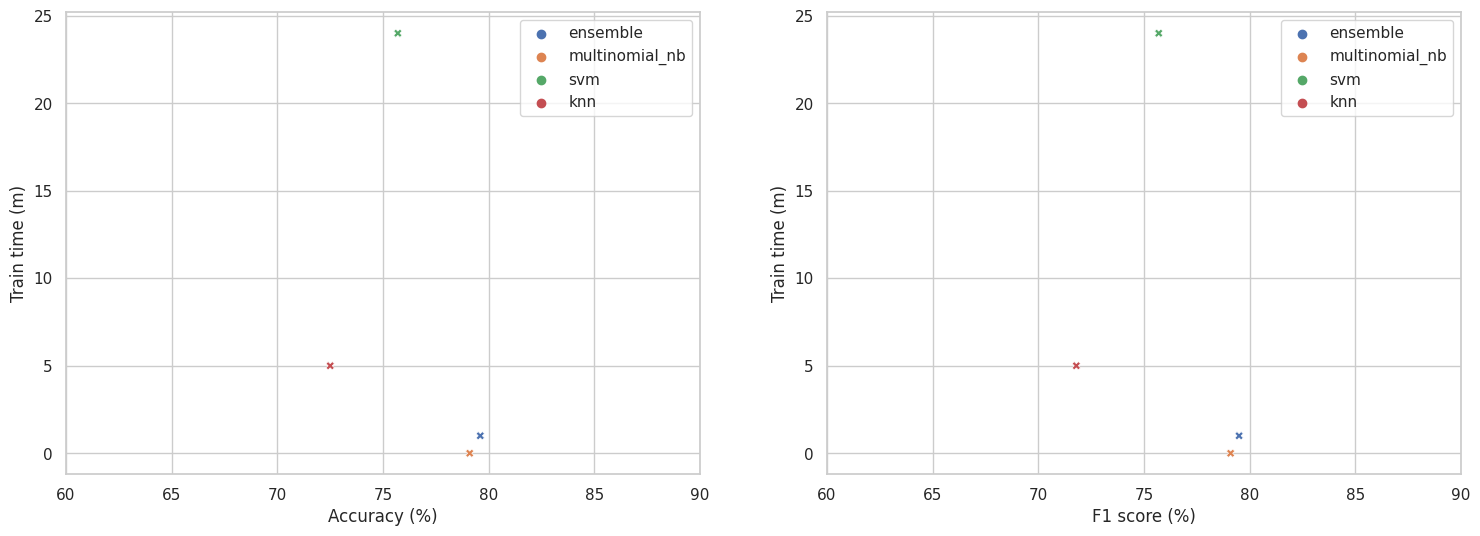

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax = sns.scatterplot(
    data=df, 
    y=df["train_time"] // 60,
    x=df["accuracy_score"] * 100,
    hue=df.index,
    marker="X",
    ax=ax1)
_ = ax.axes.set(ylabel ="Train time (m)", xlabel = "Accuracy (%)")

_ = ax.set_xlim(60, 90)

ax = sns.scatterplot(
    data=df, 
    y=df["train_time"] // 60,
    x=df["f1_score"] * 100,
    hue=df.index,
    marker="X",
    ax=ax2)
_ = ax.axes.set(ylabel ="Train time (m)", xlabel = "F1 score (%)")

_ = ax.set_xlim(60, 90)